<a href="https://colab.research.google.com/github/sowrabh04/Projects/blob/main/Another_copy_of_HW3_NLP_airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\##HW3_NLP using John Snow Labs.

*Make sure that you read through the instructions before running the code*

John Snow Labs is an application that is built specifically for Spark NLP. You can find more details here (https://nlp.johnsnowlabs.com/) https://sparknlp.org/api/python/user_guide/custom_pipelines.html

Direct your browser to the Inside Airbnb data depository website at http://insideairbnb.com/get-the-data.html. Scroll down to the ‘Data Downloads’ and make a selection of a city that you would like to investigate. For HW3 you are going to Download the ‘reviews.csv.gz’ file and save it to your computer. You may select the same city you did for the previous HW or choose a new one. NOTE: This code is setup as an analysis on an English language dataset and it might not translate the same into other languages. You might need to use the dataset of an English speaking city for this assignment to run smoothly.

In [ ]:
# This is to setup PySpark and Spark NLP on Colab
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2024-04-08 23:22:56--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2024-04-08 23:22:56--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [text/plain]
Saving to: ‘STDOUT’

-                     0%[                    ]       0  --.-KB/s               Installing PySpark 3.2.3 and Spark NLP 5.3.3
setup Colab for PySpark 3.2.3 an

This code initiates a spark session through spark-nlp and displays the version of Spark NLP and Spark that is currently running in our notebook.

In [ ]:
import sparknlp
spark = sparknlp.start()

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 5.3.3
Apache Spark version: 3.2.3


Here you will need to upload your dataset (reviews.csv) that you downloaded from http://insideairbnb.com/get-the-data/ and extracted. This dataset contains the actual reviews of the airbnb stays that we have referenced throughout the other homeworks this semester. Note: In this code I have connected my Google Drive but you may also just [upload your file in the temp folders](https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/) available in Google colab

In [ ]:
reviewsDF = spark.read.options(mode='FAILFAST',
                               header= True, multiline = True, inferSchema=True, escape='"').csv('/content/reviews.csv')

In [ ]:
reviewsDF.dtypes

[('listing_id', 'bigint'),
 ('id', 'bigint'),
 ('date', 'string'),
 ('reviewer_id', 'int'),
 ('reviewer_name', 'string'),
 ('comments', 'string')]

This code is something that I did to limit the amount of data that I was using from the dataset. This is to conserve on time sitting at the computer. The more data that you include in your model, the closer that your model will be to the actual topics but is more computationally expensive and will take a lot more time since we are running in a psuedo-spark environment and not an actual cluster computing scenario.

Make your choice about how accurate you want to be and how long you want to wait for the code to run.

In [ ]:
### Split Dataset
(extraDF,useDF) = reviewsDF.randomSplit((0.75,0.25),seed=42)

This is the only data-cleaning that we are going to get into in the current moment and it is assigning our text column to a variable name and cleaning out rows that are missing in the dataset.

In [ ]:
from pyspark.sql import functions as F

text_col = 'comments'
review_text = useDF.select("listing_id","id",text_col).filter(F.col(text_col).isNotNull())

##ScreenShot #1 -
 Take a screen shot of the top 5 comments in your new dataset.

In [ ]:
review_text.head(5)

[Row(listing_id=2115, id=198932959, comments='A perfect place and host, thank you for the wonderful experience.'),
 Row(listing_id=2115, id=338964859, comments="A beautiful and clean Airbnb. Was greeted by Helen, the owner who very kindly let us check in early(8.20am) even though it was stated check in time was 2pm. Explained and showed us where everything was. Bed was comfortable and very clean. Rooms were spacious, tidy and clean. Good selection of breakfast to choose from. Cookies were delicious and that's why we emptied out the jar. Really liked this place and would strongly recommend it to anyone."),
 Row(listing_id=2115, id=409896853, comments='Great place to stay, fantastic location south of the river in a quiet neighbourhood.'),
 Row(listing_id=2115, id=412993811, comments='Great peaceful location, loved the sight and sound of the parrots in the morning. There is a wonderful park just across the road. You have the the option of nearby buses or trains to and from Perth City. The

#NLP Pipeline Construction

Here we are beginning to create our pipeline for Natural Language Processing. Be mindful of all of your Input and Output columns as the order is important when fitting the model on the data and running our model.


###Document Assembly -
The Document Assembler takes the raw text data and converts it into a format that can be tokenized. It becomes one of spark-nlp native object types, the "Document".

In [ ]:
from sparknlp.base import DocumentAssembler
documentAssembler = DocumentAssembler().setInputCol(text_col).setOutputCol('document')

# Tokenizer -

The Tokenizer takes data that is of the "Document" type and tokenizes it. While slightly more involved than this, this is effectively taking a string and splitting it along with spaces, so each word is its own string. The data then becomes the spark-nlp native type "Token".

In [ ]:
from sparknlp.annotator import Tokenizer
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('tokenized')

# Normalizer -

The normalizer will group words together based on similar semantic meaning.

In [ ]:
from sparknlp.annotator import Normalizer
normalizer = Normalizer().setInputCols(['tokenized']).setOutputCol('normalized').setLowercase(True)

#Lemmatizer -
In lemmatization we are going to reduce a given word to its root word.

There are two options in doing this in most NLP applications you will see either Lemmatizing or Stemming. For a brief discussion of both see (https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221)



In [ ]:
from sparknlp.annotator import LemmatizerModel
lemmatizer = LemmatizerModel.pretrained().setInputCols(['normalized']).setOutputCol('lemmatized')

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


#Stop Words -
The purpose of this stage is to remove words that are too common to the English language that they do not add value to an analysis.

In [ ]:
# Import the required modules and classes
from sparknlp.base import DocumentAssembler, Pipeline
from sparknlp.annotator import (
    SentenceDetector,
    Tokenizer,
    StopWordsCleaner)

# Step 3: Performs stopwords cleaning
stop_words = (
    StopWordsCleaner().pretrained("stopwords_iso","en")
    .setInputCols(["lemmatized"])
    .setOutputCol("unigrams")
)

stopwords_iso download started this may take some time.
Approximate size to download 2.1 KB
[OK!]


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get English stop words list
eng_stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sparknlp.annotator import StopWordsCleaner

stopwords_cleaner = StopWordsCleaner().setInputCols(['lemmatized']).setOutputCol('unigrams').setStopWords(eng_stopwords)

#NGram Generator
The NGramGenerator converts the input array of strings into an array of n-grams (annotatorType CHUNK). It returns an array of n-grams where each n-gram is represented by a space-separated string of words.

In [ ]:
from sparknlp.annotator import NGramGenerator

ngrammer = NGramGenerator() \
    .setInputCols(['lemmatized']) \
    .setOutputCol('ngrams') \
    .setN(3) \
    .setEnableCumulative(True) \
    .setDelimiter('_')

These next two cells (pos_tagger [link text](https://nlp.johnsnowlabs.com/docs/en/annotators#postagger-part-of-speech-tagger/) and [chunker](https://https://nlp.johnsnowlabs.com/docs/en/annotators#chunker)) are modification transformers to try to keep only relevant parts-of-speech with our n-grams. Meaning we would keep Adj + Noun (great house) and drop Prep + Adj (for everyone)

In [ ]:
from sparknlp.annotator import PerceptronModel
pos_tagger = PerceptronModel.pretrained('pos_anc').setInputCols(['document', 'lemmatized']).setOutputCol('pos')

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


In [ ]:
from sparknlp.annotator import Chunker
allowed_tags = ['<JJ>+<NN>', '<NN>+<NN>']
chunker = Chunker().setInputCols(['document', 'pos']).setOutputCol('ngrams').setRegexParsers(allowed_tags)

# The Finisher -
Helps the end user by transforming the processed data in the annotation format of Spark NLP into a “human-readable” format

In [ ]:
from sparknlp.base import Finisher
finisher = Finisher().setInputCols(['unigrams','ngrams'])

## Pipeline - Creating and Running

In [ ]:
from pyspark.ml import Pipeline
pipeline1 = Pipeline().setStages([documentAssembler,
                 tokenizer,
                 normalizer,
                 lemmatizer,
                 stopwords_cleaner,
                 pos_tagger,
                 chunker,
                 finisher])

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline().setStages([documentAssembler,
                 tokenizer,
                 normalizer,
                 lemmatizer,
                 stop_words,
                 pos_tagger,
                 chunker,
                 finisher])

In [ ]:
processed_review = pipeline.fit(review_text).transform(review_text)



These next steps here are going to be processing the output of reviews that have gone through your pipeline and are now going to be accessible for the LDA process.



In [ ]:
processed_review.limit(5).show()


+----------+---------+--------------------+--------------------+--------------------+
|listing_id|       id|            comments|   finished_unigrams|     finished_ngrams|
+----------+---------+--------------------+--------------------+--------------------+
|      2115|198932959|A perfect place a...|[perfect, place, ...|[perfect place, w...|
|      2115|338964859|A beautiful and c...|[beautiful, clean...|[spacious, tidy, ...|
|      2115|409896853|Great place to st...|[great, place, st...|[Great place, fan...|
|      2115|412993811|Great peaceful lo...|[great, peaceful,...|[Great peaceful l...|
|      2115|482834638|Thank you Helen f...|[thank, helen, be...|[fantastic locati...|
+----------+---------+--------------------+--------------------+--------------------+



In [ ]:
from pyspark.sql.functions import concat
processed_review = processed_review.withColumn('final',
     concat(F.col('finished_unigrams'),
            F.col('finished_ngrams')))



#ScreenShot #2 -

Take a screenshot of the final line of unigrams and n-grams that will be going into the CountVectorizer.

In [ ]:
processed_review.select('final').limit(5).show(truncate=90)

+------------------------------------------------------------------------------------------+
|                                                                                     final|
+------------------------------------------------------------------------------------------+
| [perfect, place, host, thank, wonderful, experience, perfect place, wonderful experience]|
|[beautiful, clean, airbnb, greet, helen, owner, kindly, let, check, earlyam, state, che...|
|[great, place, stay, fantastic, location, south, river, quiet, neighbourhood, Great pla...|
|[great, peaceful, location, love, sight, sound, parrot, morning, wonderful, park, road,...|
|[thank, helen, beau, thoroughly, love, feel, like, home, clean, comfy, fantastic, locat...|
+------------------------------------------------------------------------------------------+



# Count Vectorizer

Vectorizing our text data means that we are converting our words and in this model combination of words (n-grams) and making them into numbers based on their location in the doccument. This helps in finding our term frequency-inverse document frequency (tf-idf)
https://spark.apache.org/docs/latest/ml-features#countvectorizer

*Note: Depending on the size of the dataset that you are running this on, this next step of fitting the model and transforming the dataframe will take up to half an hour so be mindful before you run this next cell. *

In [ ]:
from pyspark.ml.feature import CountVectorizer

tfizer = CountVectorizer(inputCol='final', outputCol='tf_features')
tf_model = tfizer.fit(processed_review)
tf_result = tf_model.transform(processed_review)

This next piece of code is performing the tf_idf process (https://naturale0.github.io/2021/02/14/LDA-1-background-topic-modelling#tf-idf-matrix) on our vectorized text corpus or all of the reviews are now numberized and this code is looking at the relationships between each of the values.

*Note: Give time for this chunk as well as this section will take around 20 mins or so.*

In [ ]:
from pyspark.ml.feature import IDF

idfizer = IDF(inputCol='tf_features', outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)

#Latent Dirchlet Allocation (LDA)
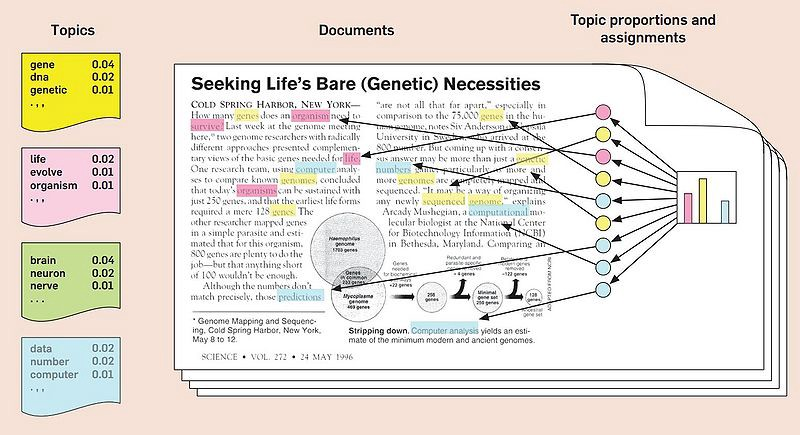



LDA is a generative model that assumes that documents are represented by a distribution of topics and topics are represented by a distribution of words. Given the TF-IDF scores for the vocabulary, LDA can identify the predefined number of topics within the data.

**CHANGE THE NUMBER OF TOPICS** from the number in this code.

You can change the number of topics as you need to depending on the dataset and there are several methods and philopsophies on doing this. This is one of many packages that will evaluate topics (https://github.com/mind-Lab/octis)

*Note: This next portion is also going to take around 20 minutes to complete depending on your dataset.*

In [ ]:
from pyspark.ml.clustering import LDA

num_topics = 12. # you can change this to any number of topics that you think might be in the dataset.
max_iter = 10

lda = LDA(k=num_topics, maxIter=max_iter, featuresCol='tf_idf_features')
lda_model = lda.fit(tfidf_result)

In [ ]:
from pyspark.sql import types as T

vocab = tf_model.vocabulary

def get_words(token_list):
     return [vocab[token_id] for token_id in token_list]

udf_to_words = F.udf(get_words, T.ArrayType(T.StringType()))

#Screen Shot #3 -

This is the top 10 words of your LDA model topics. Take a screenshot of the words and see if you can assign names for the different topics as you understand them based on the words in your printout. If you would like to see more words from each topic then change the 'num_top_words' variable.

In [ ]:
from os import truncate
num_top_words = 10

topics = lda_model.describeTopics(num_top_words).withColumn('topicWords', udf_to_words(F.col('termIndices')))
topics.select('topic', 'topicWords').show(truncate=False)



/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-----+-----------------------------------------------------------------------------------------------------------+
|topic|topicWords                                                                                                 |
+-----+-----------------------------------------------------------------------------------------------------------+
|0    |[place, house, great, stay, fab, thank, host, comfortable accommodation, beautiful, location]              |
|1    |[great, stay, location, beautiful, place, house, lovely, apartment, love, walk]                            |
|2    |[en, home, house, een, stay, great, awesome, lovely, place, city center]                                   |
|3    |[und, de, et, sehr, die, ist, wir, la, war, est]                                                           |
|4    |[excellent location, Great value, good, great, house, good place, place, location, Good place, stay]       |
|5    |[Awesome place, Wonderful place, place, stay, Excellent place, Ni

The following is another way of looking at the dataset with topicDistributions...

In [ ]:
# Shows the result
transformed = lda_model.transform(tfidf_result)
transformed.show(20)
#transformed.filter(transformed.listing_id=='69352').show(10)

+----------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|listing_id|                id|            comments|   finished_unigrams|     finished_ngrams|               final|         tf_features|     tf_idf_features|   topicDistribution|
+----------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      2115|         198932959|A perfect place a...|[perfect, place, ...|[perfect place, w...|[perfect, place, ...|(262144,[2,6,13,2...|(262144,[2,6,13,2...|[0.00292844839637...|
|      2115|         338964859|A beautiful and c...|[beautiful, clean...|[spacious, tidy, ...|[beautiful, clean...|(262144,[2,4,8,10...|(262144,[2,4,8,10...|[0.05888461616633...|
|      2115|         409896853|Great place to st...|[great, place, st...|[Great place, fan...|[great, pla

Here are the data types present in the dataset...

In [ ]:
transformed.dtypes

[('listing_id', 'bigint'),
 ('id', 'bigint'),
 ('comments', 'string'),
 ('finished_unigrams', 'array<string>'),
 ('finished_ngrams', 'array<string>'),
 ('final', 'array<string>'),
 ('tf_features', 'vector'),
 ('tf_idf_features', 'vector'),
 ('topicDistribution', 'vector')]

Lets say I want to piece out how to see which topics are prominent for each document (in this case we would be looking at individual reviews). The following code splits our vector array of topicDistribution across documents instead of across words. Now I can see the topic loadings for each document id. This information can be valuable for other testing.

*Note: Make sure you adjust the documentTopics_df to reflect the number of topics that you have in your model.*

In [ ]:
from pyspark.ml.feature import VectorAssembler

docTopDF = transformed.select("listing_id","topicDistribution")

def extract(row):
    return (row.listing_id,) + tuple(row.topicDistribution.toArray().tolist())

documentTopics_df = docTopDF.rdd.map(extract).toDF(["listing_id", "topic1","topic2","topic3","topic4", "topic5","topic6"])
documentTopics_df.show()


+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|listing_id|              topic1|              topic2|              topic3|              topic4|              topic5|              topic6|                  _8|                  _9|                 _10|                 _11|                 _12|                 _13|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      2115|0.002928448396374069|  0.9672976924422788|0.002888965872050...|0.002873110372635...|0.002931793444692...|0.002908923655454...|0.003562068215103944|0.002919476169175...|0.002912029954357328|0.00

This is a way to see the avg topic loading for each Listed house. So that maybe I could make some inferences about different listings or tag them with key words for people to search the AirBnB site.

In [ ]:
averages_df = documentTopics_df.groupBy("listing_id").avg("topic1", "topic2", "topic3","topic4","topic5","topic6")
averages_df.show(12)


+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|listing_id|         avg(topic1)|         avg(topic2)|         avg(topic3)|         avg(topic4)|         avg(topic5)|         avg(topic6)|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    787999| 0.03625122919962838| 0.18961550082501993|0.004817814543117574|0.050323079921508904| 0.05714501398016065| 0.06243966599876444|
|   1653068| 0.03327099081713808|  0.3462230039043023|0.001122587775393...|0.001116426123185696|0.007158165432324713|0.001130342083005792|
|   8561911|0.016966638167720986| 0.41341112606195923|0.001492076877305...| 0.03440157294584084| 0.04069876344985664|0.023231144982028596|
|   9778785| 0.04405290040475174| 0.24386798661862955|0.001070945027303...| 0.04807937776223887| 0.02854132656274868|0.002789101099265447|
|   9964925|0.0071545383144

In [ ]:
averages_df.filter(averages_df.listing_id=='1078').show()


+----------+-----------+-----------+-----------+-----------+-----------+-----------+
|listing_id|avg(topic1)|avg(topic2)|avg(topic3)|avg(topic4)|avg(topic5)|avg(topic6)|
+----------+-----------+-----------+-----------+-----------+-----------+-----------+
+----------+-----------+-----------+-----------+-----------+-----------+-----------+



# Going Further

Now we can add another application to our understanding of the dataset and see if the topics being discussed can be used to predict whether or not the host is a superhost. We will use the RandomForestClassifier from the included pyspark ml library.

This next code loads up the expanded **listings.csv** from insideairbnb that was used for HW #2 (It is okay if you have to change to an English speaking city)

In [ ]:
listingsDF =spark.read.options(mode='FAILFAST',
                              header = True,
                              multiLine=True,
                              inferSchema=True,
                              escape='"').csv("/content/listings.csv") #You will need to replace this with your file path

In [ ]:
listingsDF = listingsDF.select("id","host_name","host_is_superhost","number_of_reviews", "review_scores_rating", "price")


Here we are combining our '**listingsDF**' with the '**documentTopics_df**' that we made at the end of the LDA topic modeling. This is a join in pyspark that will combine the two dataframes by an id column.

For this particular join, we have a duplicate column name ('*id*') in both dataframes but we want to keep the one in the documentTopics_df and will drop the one in listingsDF

In [ ]:
totalsDF = documentTopics_df.join(listingsDF,documentTopics_df.listing_id == listingsDF.id).drop(listingsDF.id)
totalsDF.show(truncate=True)

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----------------+-----------------+--------------------+-------+
|listing_id|              topic1|              topic2|              topic3|              topic4|              topic5|              topic6|                  _8|                  _9|                 _10|                 _11|                 _12|                 _13|host_name|host_is_superhost|number_of_reviews|review_scores_rating|  price|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----------------+-----------------+----------

#Screenshot #4 -

Here I am converting the *'host_is_superhost'* column into a 'dummy variable' where it will be a binary (1,0) column simplified to *'superhost*'. Take a screenshot of the show() call of the dataframe before going into the transformation for the RandomForest model.

*Note: Again be mindful that transformations will take some computation time.*

In [ ]:
from pyspark.ml.feature import StringIndexer
totalsDF = StringIndexer(
    inputCol='host_is_superhost',
    outputCol='superhost',
    handleInvalid='keep').fit(totalsDF).transform(totalsDF)

totalsDF.show(5, truncate=True)

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----------------+-----------------+--------------------+-------+---------+
|listing_id|              topic1|              topic2|              topic3|              topic4|              topic5|              topic6|                  _8|                  _9|                 _10|                 _11|                 _12|                 _13|host_name|host_is_superhost|number_of_reviews|review_scores_rating|  price|superhost|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----------------+--------

Hre we are defining the independent variables that we are going to include into our RandomTreeClassifier model. You can decide to include additional variables from the listings.csv dataframe and build out a robust model but here I am only including the LDA discovered topics from the text of the reviews.

In [ ]:
required_features = ['topic1','topic2','topic3','topic4','topic5','topic6'] # Make sure that you adjust this code to the number of topics that you have
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=required_features, outputCol='features')
transformed_data = assembler.transform(totalsDF)

In [ ]:
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol='superhost',
                            featuresCol='features',
                            maxDepth=5)

ON a large dataset be prepared for this to take awhile to run. Approximately an hour

In [ ]:
model = rf.fit(training_data)


In [ ]:
predictions = model.transform(test_data)

In [ ]:
# Evaluate our model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol='superhost',
    predictionCol='prediction',
    metricName='accuracy')

#Screenshot  #5 -
This is the printout of the accuracy of the model predicting whether or not the airbnb host is a superhost. Take a screenshot of the printout cell of your models test accuracy. Though this is not the end all, be all for evaluating a RandomForest Classifier, it is a helpful measure in seeing how useful your model is making a prediction.

In [ ]:
accuracy = evaluator.evaluate(predictions)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.6381532185790662


This is a code to look at the importance of features in the model when assisting the classification model. This can be an important component of our interpretation if we can look at different factors that really influence the predictions that we are making.

In [ ]:
import pandas as pd
featureImp = pd.DataFrame(
list(zip(assembler.getInputCols(), model.featureImportances)),columns=["features", "importance"])
featureImp.sort_values(by="importance", ascending=False)

,features,importance
4,topic5,0.315685
1,topic2,0.244289
3,topic4,0.241637
5,topic6,0.111872
2,topic3,0.053231
0,topic1,0.033286


## Screenshot #6
BONUS - Go through some of the John Snow Labs documentation and tutorials (https://nlp.johnsnowlabs.com/models?type=pipeline) and https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/tutorials/Certification_Trainings/Public


And apply a new technique to our dataset. You will have to write your own code here. You do not need a new dataset (not another city download) but a new analytics applied to the same dataset that you already have preloaded.